<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Arshia Dadras
### Student Number : 99109109
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(.1307, .3081)
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv = nn.Conv2d(in_size, out_size, 3, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_size)
        
    def forward(self, x):
        return F.relu(self.batchnorm(self.conv(x)))
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.convblock1 = ConvBlock(in_size, hidden_size)
        self.convblock2 = ConvBlock(hidden_size, out_size)
        
    def forward(self, x):
        return x + self.convblock2(self.convblock1(x))
    
        
class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            ConvBlock(1, 16),
            nn.MaxPool2d(2),
            ResidualBlock(16, 16, 16),
            nn.MaxPool2d(2),
            ConvBlock(16, 64),
            ResidualBlock(64, 64, 64),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10),
        )
        
    def forward(self, x):
        return F.log_softmax(self.network(x), dim=1)

# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################

model = ResidualClassifier().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################

total_step = len(train_loader)
num_epochs = 20

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []
for epoch in range(num_epochs):
    model.train()
    total_loss, total_accuracy = 0, 0
    for batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        total_loss += loss.item() * len(output)
        
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        total_accuracy += pred.eq(labels.data.view_as(pred)).sum().item()
        
        if (batch + 1) % 250 == 0:
            print(f'Epoch: {epoch+1:2d}/{num_epochs} - Batch: {batch+1:4d}/{len(train_loader)} - Training Loss: {loss.item():.4f}')
    print('- ' * 28)
    
    total_loss /= len(train_loader.dataset)
    total_accuracy /= len(train_loader.dataset)
    train_loss.append(total_loss)
    train_accuracy.append(total_accuracy)
    
    with torch.no_grad():
        model.eval()
        total_loss, total_accuracy = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            total_loss += F.nll_loss(output, labels, reduction='sum')
            
            pred = output.argmax(dim=1, keepdim=True)
            total_accuracy += pred.eq(labels.data.view_as(pred)).sum().item()
            
        total_loss /= len(val_loader.dataset)
        total_accuracy /= len(val_loader.dataset)
        val_loss.append(total_loss)
        val_accuracy.append(total_accuracy)
        
        print(' ' * 20, f'[Epoch {epoch+1:2d}/{num_epochs:2d}]')
        print(f'      Train Loss: {train_loss[-1]:.4f} - Train Accuracy: {train_accuracy[-1] * 100:.2f}%')
        print(f' Validation Loss: {total_loss:.4f} - Validation Accuracy: {total_accuracy * 100:.2f}%')
        print('- ' * 28)
        
    torch.cuda.empty_cache()

Epoch:  1/20 - Batch:  250/3125 - Training Loss: 0.2621
Epoch:  1/20 - Batch:  500/3125 - Training Loss: 0.2769
Epoch:  1/20 - Batch:  750/3125 - Training Loss: 0.5233
Epoch:  1/20 - Batch: 1000/3125 - Training Loss: 0.0744
Epoch:  1/20 - Batch: 1250/3125 - Training Loss: 0.2150
Epoch:  1/20 - Batch: 1500/3125 - Training Loss: 0.0311
Epoch:  1/20 - Batch: 1750/3125 - Training Loss: 0.0339
Epoch:  1/20 - Batch: 2000/3125 - Training Loss: 0.1747
Epoch:  1/20 - Batch: 2250/3125 - Training Loss: 0.0616
Epoch:  1/20 - Batch: 2500/3125 - Training Loss: 0.0149
Epoch:  1/20 - Batch: 2750/3125 - Training Loss: 0.0732
Epoch:  1/20 - Batch: 3000/3125 - Training Loss: 0.1164
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                     [Epoch  1/20]
      Train Loss: 0.1778 - Train Accuracy: 95.65%
 Validation Loss: 0.0634 - Validation Accuracy: 98.19%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Epoch:  2/20 - Batch:  250/3125 - Training Loss: 0.0359
Epoch:  2/20 - Bat

Epoch: 10/20 - Batch:  250/3125 - Training Loss: 0.0001
Epoch: 10/20 - Batch:  500/3125 - Training Loss: 0.0021
Epoch: 10/20 - Batch:  750/3125 - Training Loss: 0.0003
Epoch: 10/20 - Batch: 1000/3125 - Training Loss: 0.0211
Epoch: 10/20 - Batch: 1250/3125 - Training Loss: 0.0009
Epoch: 10/20 - Batch: 1500/3125 - Training Loss: 0.0048
Epoch: 10/20 - Batch: 1750/3125 - Training Loss: 0.2221
Epoch: 10/20 - Batch: 2000/3125 - Training Loss: 0.0002
Epoch: 10/20 - Batch: 2250/3125 - Training Loss: 0.0009
Epoch: 10/20 - Batch: 2500/3125 - Training Loss: 0.0249
Epoch: 10/20 - Batch: 2750/3125 - Training Loss: 0.0001
Epoch: 10/20 - Batch: 3000/3125 - Training Loss: 0.0016
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                     [Epoch 10/20]
      Train Loss: 0.0171 - Train Accuracy: 99.45%
 Validation Loss: 0.0319 - Validation Accuracy: 99.12%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Epoch: 11/20 - Batch:  250/3125 - Training Loss: 0.0025
Epoch: 11/20 - Bat

Epoch: 19/20 - Batch:  250/3125 - Training Loss: 0.0001
Epoch: 19/20 - Batch:  500/3125 - Training Loss: 0.0000
Epoch: 19/20 - Batch:  750/3125 - Training Loss: 0.0001
Epoch: 19/20 - Batch: 1000/3125 - Training Loss: 0.0002
Epoch: 19/20 - Batch: 1250/3125 - Training Loss: 0.0005
Epoch: 19/20 - Batch: 1500/3125 - Training Loss: 0.0000
Epoch: 19/20 - Batch: 1750/3125 - Training Loss: 0.0001
Epoch: 19/20 - Batch: 2000/3125 - Training Loss: 0.0009
Epoch: 19/20 - Batch: 2250/3125 - Training Loss: 0.0001
Epoch: 19/20 - Batch: 2500/3125 - Training Loss: 0.1875
Epoch: 19/20 - Batch: 2750/3125 - Training Loss: 0.0006
Epoch: 19/20 - Batch: 3000/3125 - Training Loss: 0.0002
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                     [Epoch 19/20]
      Train Loss: 0.0074 - Train Accuracy: 99.73%
 Validation Loss: 0.0371 - Validation Accuracy: 99.09%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Epoch: 20/20 - Batch:  250/3125 - Training Loss: 0.0001
Epoch: 20/20 - Bat

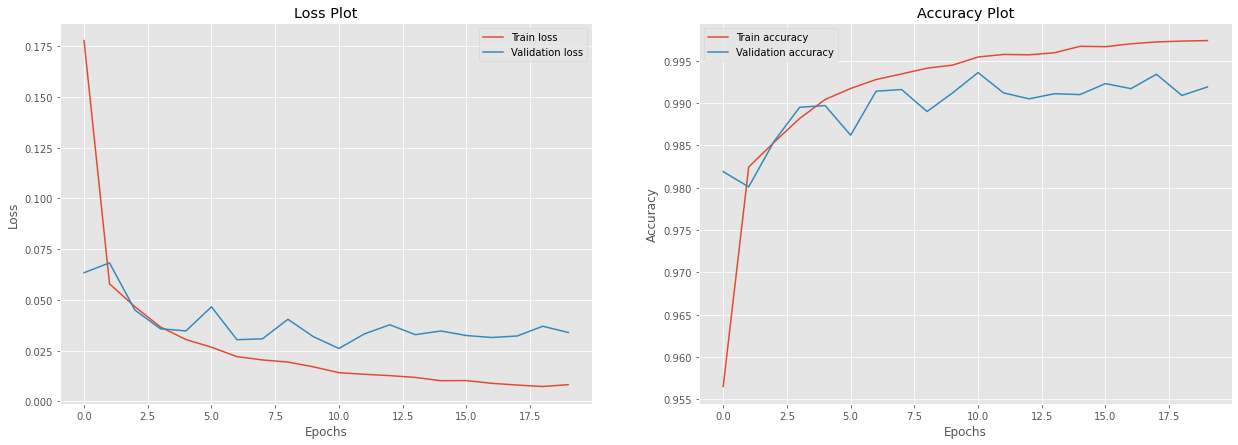

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

plt.subplots(figsize=(21,7))

loss = plt.subplot(1, 2, 1)
loss.set_title('Loss Plot')
loss.set_xlabel('Epochs')
loss.set_ylabel('Loss')
loss.plot(train_loss)
loss.plot(val_loss)
loss.legend(['Train loss', 'Validation loss'])

accuracay = plt.subplot(1, 2, 2)
accuracay.set_title('Accuracy Plot')
accuracay.set_xlabel('Epochs')
accuracay.set_ylabel('Accuracy')
accuracay.plot(train_accuracy)
accuracay.plot(val_accuracy)
accuracay.legend(['Train accuracy', 'Validation accuracy'])

plt.show()

# Test Model (20 Points)

Test F1-score: 0.9927
Test Accuracy: 99.27%


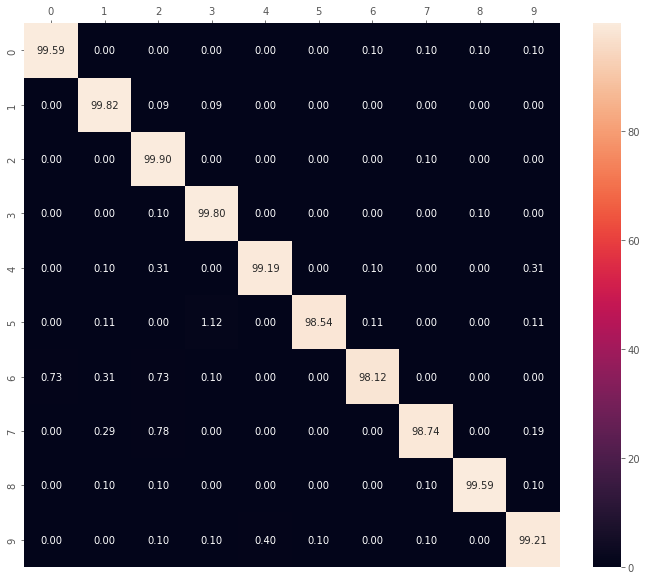

In [10]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        pred = model(images).argmax(dim=1, keepdim=True)
        
        accuracy = accuracy_score(labels, pred)
        f1 = f1_score(labels, pred, average='macro')
        confusion = confusion_matrix(labels, pred, normalize='true')
        
        plt.figure(figsize=(12,10))
        print(f'Test F1-score: {f1:.4f}')
        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        
        ax = sns.heatmap(confusion * 100, annot=True, fmt='.2f')
        ax.xaxis.tick_top()